In [1]:
from SVDModel import SVDModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import pickle
import os.path
from pathlib import Path

np.random.seed(3362)

In [2]:
PARAM = dict()
PARAM['features'] = 3
PARAM['lr'] = 0.01
PARAM['epochs'] = 501
PARAM['weight_decay'] = 0.02
PARAM['stopping'] = 0.001
PARAM['mode'] = 'svd++'

In [3]:
names = ['userId','rating','timestamp','movieId']
df_netflix = pd.read_csv('data/NetflixPrize/'+'data_1.txt', names=names, low_memory=False)
df_netflix_2 = pd.read_csv('data/NetflixPrize/'+'data_2.txt', names=names, low_memory=False)
df_netflix_3 = pd.read_csv('data/NetflixPrize/'+'data_3.txt', names=names, low_memory=False)
df_netflix_4 = pd.read_csv('data/NetflixPrize/'+'data_4.txt', names=names, low_memory=False)
df_netflix = pd.concat([df_netflix,df_netflix_2,df_netflix_3,df_netflix_4], names=names)
df_netflix['movieId'] = df_netflix['movieId'].fillna(method='ffill')
df_netflix.dropna(inplace=True)
df_netflix['rating'] = df_netflix['rating'].astype(np.int8)
df_netflix['movieId'] = df_netflix['movieId'].astype(np.int16)
df_netflix['userId'] = df_netflix['userId'].astype(np.int32)
df_netflix['timestamp'] = pd.to_datetime(df_netflix['timestamp']).view(dtype=np.int64) // 10 ** 9
df_movies = pd.read_csv('data/NetflixPrize/'+'movie_titles.csv',
                        encoding='latin-1',
                        names=['movieId','release_year','title'],
                        usecols=range(3))
NETFLIX = {
  'ratings': df_netflix[['userId','movieId','rating','timestamp']].sample(2**16),
  'movies': df_movies,
  'm_movies': df_netflix['movieId'].nunique(),
  'n_users': df_netflix['userId'].nunique(),
  'n_ratings': len(df_netflix)
}
print(NETFLIX['ratings'].shape)
print(NETFLIX['movies'].shape)

(65536, 4)
(17770, 3)


In [4]:
print('Creating SVD Model')
svd = SVDModel()
print("Created\nLoading Data")
svd.data_loader(data=NETFLIX['ratings'],
                n_items = NETFLIX['m_movies'],
                n_users= NETFLIX['n_users'])
print("Loaded Data\nSpliting Data")
svd.split(0.8,0.8)
print("Splitted Data")

Creating SVD Model
Created
Loading Data
Loaded Data
Spliting Data
User Item Matrix Shape: (54794, 7938)
User Reference length: 54794
Item Reference length: 7938
Splitted Data


In [5]:
def train_model(features, lr, epochs, weight_decay, mode):
    print("Training")
    # if os.path.isfile(f'./model_netflix/svdpp/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
    #     return
    print(f"==============================")
    print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
 
    svd.features = features
    svd.lr = lr
    svd.epochs = epochs
    svd.weight_decay = weight_decay
    svd.mode = mode
    svd.stopping = PARAM['stopping']
 

    print("Splitted Data\nTraining...")
    start = time.perf_counter()
    result = svd.training()
    print('Time used =', time.perf_counter()-start)
   
    print('Saving Model')
    Path(f"./model_netflix").mkdir(parents=True, exist_ok=True)
    Path(f"./model_netflix/svdpp").mkdir(parents=True, exist_ok=True)
    Path(f"./model_netflix/svdpp/model").mkdir(parents=True, exist_ok=True)
    Path(f"./model_netflix/svdpp/result").mkdir(parents=True, exist_ok=True)
   
   
    # with open(f'./model_netflix/svdpp/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
    #     pickle.dump(svd, out, pickle.HIGHEST_PROTOCOL)
    #     out.close()
    with open(f'./model_netflix/svdpp/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
        pickle.dump(result, out, pickle.HIGHEST_PROTOCOL)
        out.close()
    print(f"==============================")
    return svd, result

In [6]:
res_svd, result = train_model(PARAM['features'],PARAM['lr'],PARAM['epochs'],PARAM['weight_decay'],PARAM['mode'] ) 

Training
features: 3
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001

Splitted Data
Training...
Epoch :    1  | Train : 1.090  | Valid : 1.143  | Time : 14.98090s
Training stopped:
Epoch :    8  | Train Loss : 0.843  | Valid Loss: 1.104  | Test Loss: 1.087
Time used = 30.400560900000016
Saving Model


In [7]:
# load result
if os.path.isfile(f"./model_netflix/svdpp/result/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl"):
  # with open(f"./model_netflix/svdpp/model/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl", 'rb') as inp:
  #   svd = pickle.load(inp)
  #   inp.close()
  with open(f"./model_netflix/svdpp/result/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl", 'rb') as inp:
    result = pickle.load(inp)
    print(result[0][-1])
    print(result[1][-1])
    print(result[2])
    print(len(result[0]))
    inp.close()
    

0.8425710530187112
1.1044224299163354
1.0868417701280622
8


In [8]:
from SVDModel import topKPrediction,movieRatePredictionByUserIdMovieId

### Definition of Relevant and Recommended

* Relevant: True Rating `>=` threshold
* Irrelevant: True Rating `<` threshold
* Recommended item: Predicted Rating `>=` threshold
* Not Recommended item: Predicted Rating `<` threshold

In [9]:
predictions = {
  'userId':[],
  'movieId':[],
  'actual':[],
  'prediction':[]
}
for i,(userId,movieId, actual,_) in svd.data.iterrows():
    # print(svd.test[i,j])
    prediction = movieRatePredictionByUserIdMovieId(userId=userId,movieId=movieId,model=svd)
    predictions['userId'].append(userId)
    predictions['movieId'].append(movieId)
    predictions['actual'].append(actual)
    predictions['prediction'].append(prediction)


In [10]:
df = pd.DataFrame(predictions)

In [11]:
df.head()

,userId,movieId,actual,prediction
0,2572942,16997,2,3.493390
1,856444,483,4,3.726194
2,2368112,13636,5,3.993300
3,1084697,5181,2,3.508658
4,17287,14670,2,3.747013


In [12]:
# Find a threshold
thresholds = np.arange(0,5.1,0.5)
res = {
  'precision':[],
  'recall':[],
  'f1':[]
}

from numba import njit, prange
 
@njit
def findThreshold(df, threshold):
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0
  precision = 0
  recall = 0
  for i in prange(len(df)):
    _,_,actual,prediction = df[i]
    if actual >= threshold:
      if prediction >= threshold:
        true_positive+=1
      else:
        false_negative+=1
    else:
      if prediction >= threshold:
        false_positive+=1
      else:
        true_negative+=1
  precision = true_positive / (true_positive + false_positive) if true_positive + false_positive!=0 else 0
  recall = true_positive / (true_positive + false_negative) if true_positive + false_negative!=0 else 0
  f1 = 2 * (precision * recall) / (precision + recall)  if true_positive + false_positive!=0 and true_positive + false_negative!=0 else 0
  return precision,recall,f1

for threshold in thresholds:
  precision, recall,f1 = findThreshold(df.to_numpy(),threshold)
  res['precision'].append(precision)
  res['recall'].append(recall)
  res['f1'].append(f1)
df_res = pd.DataFrame(res, index=thresholds)
df_res


,precision,recall,f1
0.0,1.000000,1.000000,1.000000
0.5,1.000000,1.000000,1.000000
1.0,1.000000,1.000000,1.000000
1.5,0.953781,1.000000,0.976344
2.0,0.953781,1.000000,0.976344
2.5,0.852990,0.999982,0.920656
3.0,0.862456,0.987674,0.920828
3.5,0.694998,0.830674,0.756803
4.0,0.878561,0.191577,0.314561
4.5,0.838074,0.025369,0.049248


the optimal threshold = `3.0`

In [13]:
from collections import defaultdict

user = defaultdict(list)
for i, (uid, _, actual, prediction) in df.iterrows():
  user[int(uid)].append((actual, prediction))


In [14]:
threshold = 3

k = range(1,21)
stat = {
    'mAP':[],
    'average recalls':[],
}
for i in k:
    PatK_byUser = dict()
    APatK_byUser = dict()
    recalls = dict()
    for userId, user_ratings in user.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        relevant = [(actual >= threshold) for (_, actual) in user_ratings]
        n_relevant = sum(relevant)
        
        
        items = [(prediction >= threshold) for (prediction, _) in user_ratings[:i]]
        k_items = sum(items)
        
        relevant_in_k = [((actual >= threshold) and (prediction >= threshold)) for (prediction, actual) in user_ratings[:i]]
        n_relevant_in_k = sum(relevant_in_k)
        
        #P@K
        PatK_byUser[userId] = n_relevant_in_k / k_items if k_items != 0 else 1
        #AP@K
        APatK_byUser[userId] = 0
        
        for j,item in enumerate(relevant):
            if j >=i:
                break
            if relevant_in_k[j]:
                APatK_byUser[userId] += sum(relevant_in_k[:j+1])/(j+1)
        APatK_byUser[userId] = APatK_byUser[userId] / min(n_relevant_in_k, i) if n_relevant_in_k !=0 else 1
        
        #Recall@K
        recalls[userId] = n_relevant_in_k / n_relevant if n_relevant != 0 else 1
        
    mAP = sum(APatK_byUser.values())/len(APatK_byUser)
    stat['mAP'].append(mAP)
    stat['average recalls'].append(sum(recalls.values())/len(recalls))

In [15]:
pd.DataFrame(stat,index=k)

,mAP,average recalls
1,1.000000,0.806338
2,0.999535,0.860659
3,0.999510,0.866701
4,0.999504,0.867477
5,0.999504,0.867611
6,0.999503,0.867637
7,0.999503,0.867650
8,0.999503,0.867656
9,0.999503,0.867658
10,0.999503,0.867659


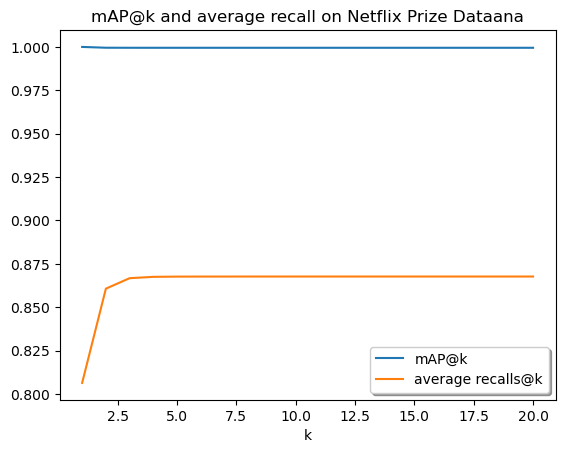

In [16]:
plt.plot(k,stat['mAP'], label="mAP@k")
plt.plot(k,stat['average recalls'], label="average recalls@k")
plt.xlabel('k')
leg = plt.legend(loc='best', shadow=True, fancybox=True)
plt.title('mAP@k and average recall on Netflix Prize Dataana')
plt.savefig(f"./model_netflix/experiment/mAP_recall.png")

In [17]:
movieRatePredictionByUserIdMovieId(userId=6,movieId=3, model=svd)

3.5834183931888717

In [18]:
topKPrediction(userId=6,k=20,model=svd)

[(7230, 4.603756287905762),
 (7057, 4.5389403634274),
 (5582, 4.533285310243237),
 (14961, 4.530233861914865),
 (12870, 4.465713746209201),
 (14550, 4.450302493663848),
 (3962, 4.3968789458533495),
 (4306, 4.385195363970147),
 (16265, 4.375042212644282),
 (11521, 4.349640678334097),
 (14103, 4.348498948020635),
 (14240, 4.3441134926198375),
 (12293, 4.335542684444431),
 (2452, 4.329315415964731),
 (8116, 4.281898152275304),
 (16954, 4.272449444321012),
 (11089, 4.269404260299795),
 (10042, 4.262417497009589),
 (6974, 4.261865949359912),
 (6205, 4.259986430464724)]